<a href="https://colab.research.google.com/github/JislordCodes/Skin_Cancer_Prediction_Model/blob/main/Skin_Cancer_Prediction_Model%26Test_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")



In [ ]:
# Set the path to your dataset directories
training_path = '/content/drive/MyDrive/archive (1)/train'  # Update with your training data path
test_path = '/content/drive/MyDrive/archive (1)/test'  # Update with your testing data path

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

def process_path(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    label = tf.where(label == 'malignant', 1, 0)
    img = process_image(file_path)
    return img, label


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for the test data


Found 2787 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
train_dataset = tf.data.Dataset.list_files(training_path + '/*/*', shuffle=True)
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)


test_dataset = tf.data.Dataset.list_files(test_path + '/*/*', shuffle=False)
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, Model, backend as K

def pre_activation_residual_block(inputs, num_filters, kernel_size=3, strides=1, activation='relu'):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation(activation)(x)
    shortcut = x

    x = layers.Conv2D(num_filters // 4, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(num_filters // 4, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(num_filters, 1, padding='same', kernel_initializer='he_normal')(x)

    if strides != 1 or inputs.shape[-1] != num_filters:
        shortcut = layers.Conv2D(num_filters, 1, strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)

    x = layers.add([x, shortcut])
    return x

def bottleneck_residual_block(inputs, num_filters, kernel_size=3, strides=1, activation='relu'):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation(activation)(x)
    shortcut = x

    x = layers.Conv2D(num_filters // 4, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(num_filters // 4, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(num_filters, 1, padding='same', kernel_initializer='he_normal')(x)

    if strides != 1 or inputs.shape[-1] != num_filters:
        shortcut = layers.Conv2D(num_filters, 1, strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)

    x = layers.add([x, shortcut])
    return x

def se_block(inputs, reduction_ratio=16):
    channels = K.int_shape(inputs)[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(channels // reduction_ratio, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    x = layers.Reshape((1, 1, channels))(x)
    return layers.multiply([inputs, x])

def resnet(input_shape, num_classes, num_blocks, num_filters=64, activation='relu', block_type='bottleneck'):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(num_filters, 7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    block_fn = bottleneck_residual_block if block_type == 'bottleneck' else pre_activation_residual_block

    for i in range(num_blocks):
        num_filters *= 2
        x = block_fn(x, num_filters, strides=2 if i == 0 else 1, activation=activation)
        x = se_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
model = resnet(input_shape=(224, 224, 3), num_classes=2, num_blocks=2)

# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, mode='min', min_lr=0.00001),
    EarlyStopping(monitor='loss', patience=15, verbose=1)
]


In [ ]:
history = model.fit(
    train_dataset,
    epochs=60,
    callbacks=callbacks
)



Epoch 1/50
88/88 [==============================] - 47s 429ms/step - loss: 0.6716 - accuracy: 0.6053 - val_loss: 0.6895 - val_accuracy: 0.5045 - lr: 1.0000e-05
Epoch 2/50
88/88 [==============================] - 35s 401ms/step - loss: 0.6009 - accuracy: 0.6968 - val_loss: 0.6614 - val_accuracy: 0.6076 - lr: 1.0000e-05
Epoch 3/50
88/88 [==============================] - 35s 399ms/step - loss: 0.5704 - accuracy: 0.7130 - val_loss: 0.6238 - val_accuracy: 0.5758 - lr: 1.0000e-05
Epoch 4/50
88/88 [==============================] - 35s 399ms/step - loss: 0.5465 - accuracy: 0.7252 - val_loss: 0.5693 - val_accuracy: 0.6227 - lr: 1.0000e-05
Epoch 5/50
88/88 [==============================] - 36s 411ms/step - loss: 0.5302 - accuracy: 0.7295 - val_loss: 0.5080 - val_accuracy: 0.6970 - lr: 1.0000e-05
Epoch 6/50
88/88 [==============================] - 36s 407ms/step - loss: 0.5188 - accuracy: 0.7298 - val_loss: 0.4702 - val_accuracy: 0.7530 - lr: 1.0000e-05
Epoch 7/50
88/88 [======================

NameError: name 'history' is not defined

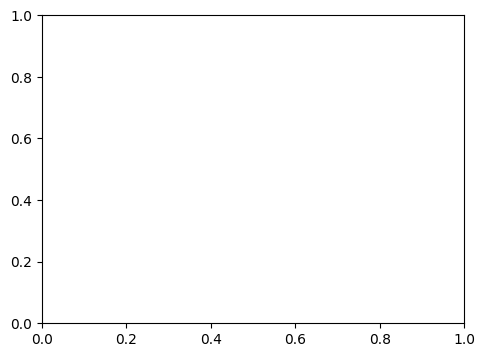

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

21/21 [==============================] - 4s 135ms/step - loss: 0.3981 - accuracy: 0.8091
Test Accuracy: 0.8090909123420715
Test Loss: 0.3980783224105835


In [ ]:
model.save("model3.h5")